In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

from random import randint

from polynomial_nets import CP_L3

from poly_VAE import Flatten, UnFlatten, VAE_CP_L3, loss_fn, VAE_Cheby_L3, VAE_Cheby3_kernel32, VAE_Cheby_L3_sparse, VAE_attention, VAE_ProdCheby, VAE_General
from poly_utils import sparse_model, non_zero_count
import poly_utils as ut
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import pandas as pd
import copy
import polynomial_nets as pn
import poly_utils as ut

#from Cuda import DeviceDataLoader

In [23]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [24]:
torch.cuda.empty_cache() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 28
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 20
IMAGE_CHANNELS = 1
RANK = 200
H_DIM = 200 

In [25]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [26]:
# Download training dataset
dataset = MNIST(root='data/', download=True)
# MNIST dataset (images and labels)
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor())

In [27]:
dataset1 = datasets.MNIST(root='data', train=True, download=True, transform=Compose([transforms.Resize(IMAGE_SIZE), ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))


In [28]:
dataset1 = datasets.FashionMNIST(root='data', train=True, download=True, transform=Compose([transforms.Resize(IMAGE_SIZE), ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

In [29]:
torch.manual_seed(0)

In [30]:
train_ds, val_ds = random_split(dataset1, [50000, 10000])


In [31]:
degrees = [4]

encoder_layer_params = [IMAGE_SIZE*IMAGE_SIZE, RANK]
decoder_layer_params = [H_DIM, RANK]

In [32]:
train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True)
#train_loader = DeviceDataLoader(train_loader, device)
val_loader = DataLoader(val_ds, BATCH_SIZE)

In [33]:
l_offset = int(IMAGE_SIZE*IMAGE_SIZE/2)
u_offset = int(IMAGE_SIZE*IMAGE_SIZE/2)

In [50]:
encoder_model = pn.CP_sparse_LU(4, IMAGE_SIZE*IMAGE_SIZE, RANK, H_DIM, l_offset = -1, u_offset = 0)
decoder_model = pn.CP_sparse_LU(4, H_DIM, RANK, IMAGE_SIZE*IMAGE_SIZE, l_offset = -1, u_offset = 0)
model = VAE_General(encoder_model, decoder_model, H_DIM, Z_DIM).to(device)

In [35]:
encoder_model = pn.CP_sparse_degree(4, IMAGE_SIZE*IMAGE_SIZE, RANK, H_DIM)
decoder_model = pn.CP_sparse_degree(4, H_DIM, RANK, IMAGE_SIZE*IMAGE_SIZE)
model = VAE_General(encoder_model, decoder_model, H_DIM, Z_DIM).to(device)

In [36]:
model.encoder.U3

Parameter containing:
tensor([[-0.0000, -0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0000],
        [ 0.0335,  0.0262,  0.0311,  ..., -0.0035, -0.0149, -0.0336],
        ...,
        [ 0.0000, -0.0000,  0.0000,  ..., -0.0000,  0.0000,  0.0000],
        [-0.0089, -0.0339, -0.0096,  ...,  0.0244, -0.0355, -0.0025],
        [-0.0013,  0.0225, -0.0077,  ..., -0.0227, -0.0193,  0.0288]],
       requires_grad=True)

In [52]:
#model = VAE_Cheby_L3_sparse(IMAGE_SIZE*IMAGE_SIZE, H_DIM, Z_DIM, RANK).to(device)
model = VAE_ProdCheby(IMAGE_SIZE*IMAGE_SIZE, encoder_layer_params, degrees, decoder_layer_params, degrees, H_DIM, Z_DIM, nn.Identity()).to(device)
model = VAE_CP_L3(IMAGE_SIZE*IMAGE_SIZE, H_DIM, Z_DIM, RANK).to(device)
#model = VAE_Cheby3_kernel32(IMAGE_SIZE, H_DIM, Z_DIM).to(device)
#print(next(model.parameters()).device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
#model = DeviceDataLoader(model, device)


In [53]:
num_param = []
for name, param in model.named_parameters():
    num = torch.count_nonzero(param)
    num_param.append(num)

torch.sum(torch.tensor(num_param))

tensor(848584)

In [54]:
ut.non_zero_count(model)

tensor(848584)

In [55]:
#model.decoder[0].layer_U1.weight.shape 
 


In [56]:
list_of_losses = []
list_of_epochs =[]
for epoch in range(NUM_EPOCHS):
    for images, _ in train_loader: 
        images = images.reshape(-1, IMAGE_SIZE*IMAGE_SIZE)   
        recon_images, mu, logvar = model(images.to(device))
        loss, bce, kld = loss_fn(recon_images.to(device), denorm(images).to(device), mu.to(device), logvar.to(device))
        #loss2 =  model.encoder.layer1.layer_C.weight @ model.encoder.layer1.layer_C.weight.T
        #loss3 = model.decoder[0].layer1.layer_C.weight.T @ model.decoder[0].layer1.layer_C.weight
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                #epochs, loss.data[0]/bs, bce.data[0]/bs, kld.data[0]/bs)
        #print(to_print)
    list_of_losses.append(loss)
    list_of_epochs.append(epoch + 1)
    print('loss', loss)
    print("Epoch : ", epoch + 1)

loss tensor(3590.0864, grad_fn=<AddBackward0>)
Epoch :  1
loss tensor(3686.8857, grad_fn=<AddBackward0>)
Epoch :  2
loss tensor(3356.3992, grad_fn=<AddBackward0>)
Epoch :  3
loss tensor(3643.4670, grad_fn=<AddBackward0>)
Epoch :  4
loss tensor(3030.7651, grad_fn=<AddBackward0>)
Epoch :  5
loss tensor(3154.4551, grad_fn=<AddBackward0>)
Epoch :  6
loss tensor(3140.2214, grad_fn=<AddBackward0>)
Epoch :  7
loss tensor(3314.9985, grad_fn=<AddBackward0>)
Epoch :  8
loss tensor(3068.1814, grad_fn=<AddBackward0>)
Epoch :  9
loss tensor(3994.2585, grad_fn=<AddBackward0>)
Epoch :  10
loss tensor(2957.3953, grad_fn=<AddBackward0>)
Epoch :  11
loss tensor(3291.3164, grad_fn=<AddBackward0>)
Epoch :  12
loss tensor(3257.1616, grad_fn=<AddBackward0>)
Epoch :  13
loss tensor(3451.4758, grad_fn=<AddBackward0>)
Epoch :  14
loss tensor(2939.7188, grad_fn=<AddBackward0>)
Epoch :  15
loss tensor(3458.0193, grad_fn=<AddBackward0>)
Epoch :  16
loss tensor(3214.9780, grad_fn=<AddBackward0>)
Epoch :  17
loss t

In [57]:
for images, _ in val_loader: 
    recon_images, mu, logvar = model(images.to(device))
    break
recon_images = recon_images.reshape(-1, 1, IMAGE_SIZE, IMAGE_SIZE)

In [58]:
#recon_images = recon_images.reshape(-1, 1, IMAGE_SIZE, IMAGE_SIZE)

In [59]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

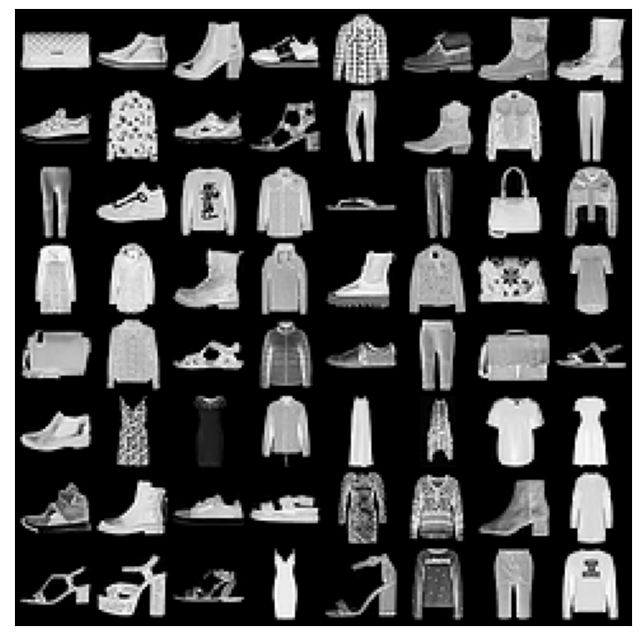

In [60]:
show_images(denorm(images))

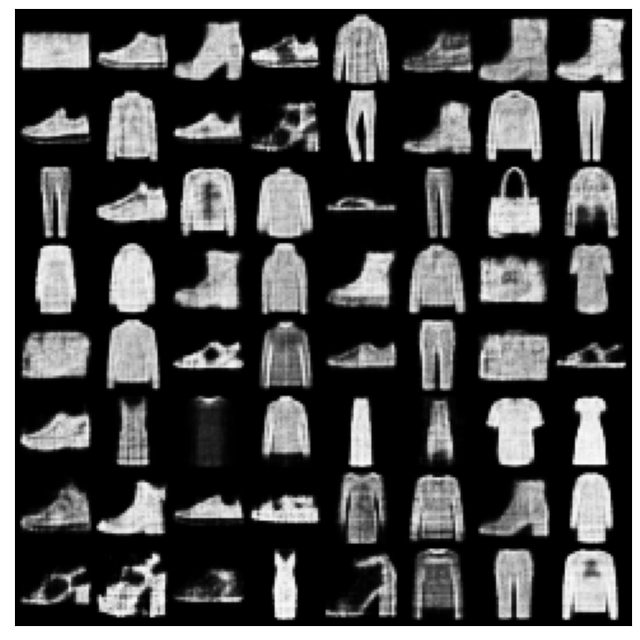

In [61]:
show_images(recon_images.to('cpu'))

In [62]:
torch.min(torch.abs(model.encoder.layer1.T1.weight))

AttributeError: 'CP_L3' object has no attribute 'layer1'

In [ ]:
mul = model.encoder.layer1.layer_C.weight.T @ model.encoder.layer1.layer_C.weight
mul.shape
eye = torch.eye(*mul.shape) 
mul - eye
eye.norm()
mul.norm()
#(mul-eye).norm()



tensor(6.6134, grad_fn=<NormBackward1>)

In [ ]:
mul_2 = model.decoder[0].layer1.layer_C.weight.T @ model.decoder[0].layer1.layer_C.weight
mul_2.shape
eye = torch.eye(*mul_2.shape) 
eye.norm()
(mul_2-eye).norm()
mul_2.norm()

tensor(29.1410, grad_fn=<NormBackward1>)

In [ ]:
for name, p in model.named_parameters():
    print(name, p.shape)

encoder.layer1.T0 torch.Size([200])
encoder.layer1.T1.weight torch.Size([200, 784])
encoder.layer1.T2.weight torch.Size([200, 784])
encoder.layer1.T3.weight torch.Size([200, 784])
encoder.layer1.T4.weight torch.Size([200, 784])
encoder.layer1.layer_C.weight torch.Size([200, 200])
encoder.layer1.layer_C.bias torch.Size([200])
fc1.weight torch.Size([100, 200])
fc1.bias torch.Size([100])
fc2.weight torch.Size([100, 200])
fc2.bias torch.Size([100])
fc3.weight torch.Size([200, 100])
fc3.bias torch.Size([200])
decoder.0.layer1.T0 torch.Size([200])
decoder.0.layer1.T1.weight torch.Size([200, 200])
decoder.0.layer1.T2.weight torch.Size([200, 200])
decoder.0.layer1.T3.weight torch.Size([200, 200])
decoder.0.layer1.T4.weight torch.Size([200, 200])
decoder.0.layer1.layer_C.weight torch.Size([784, 200])
decoder.0.layer1.layer_C.bias torch.Size([784])


In [ ]:
model_clone = copy.deepcopy(model)
model_sparse = sparse_model(model_clone, 1.2 * 10**-2)

In [ ]:
def non_zero_count(model):
    num_param = []
    for name, param in model.named_parameters():
        num = torch.count_nonzero(param)
        num_param.append(num)

    count = torch.sum(torch.tensor(num_param))    
    return count

In [ ]:
count = non_zero_count(model_sparse)

In [ ]:
for images, _ in train_loader: 
    recon_images, mu, logvar = model_sparse(images.to(device))
    break
recon_images = recon_images.reshape(-1, 1, IMAGE_SIZE, IMAGE_SIZE)

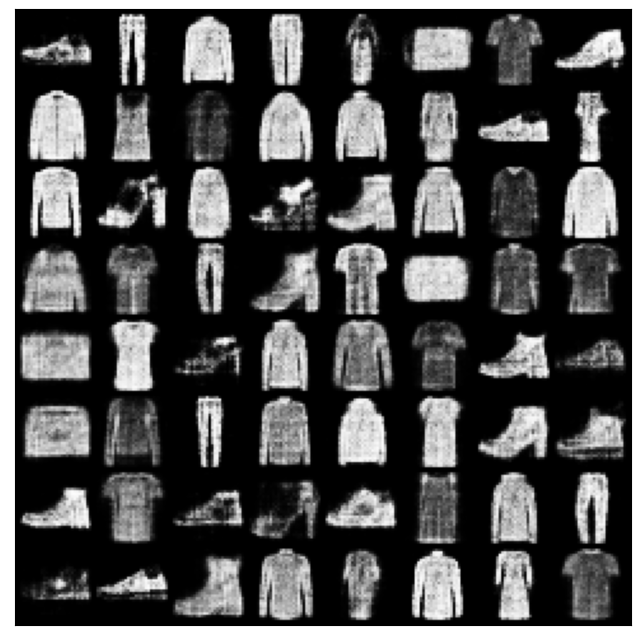

In [ ]:
show_images(recon_images.to('cpu'))

In [ ]:
e_layer_T1 = model.encoder.layer_b.weight.to('cpu')

AttributeError: 'ProdCheby_NL' object has no attribute 'layer_b'

In [ ]:
my_dict = {
    "epochs": list_of_epochs, 
    "losses": list_of_losses
}

df = pd.DataFrame(my_dict)

In [ ]:
df.style

,epochs,losses
0,1,1405.3109
1,2,1378.7654
2,3,1271.0266
3,4,1326.7499
4,5,1286.1855


In [ ]:
num_param = []
for name, param in model.named_parameters():
    num = torch.count_nonzero(param)
    num_param.append(num)

In [ ]:
torch.sum(torch.tensor(num_param))

tensor(326824)

In [ ]:
b = model.encoder.layer_b.weight.to(float)